# Carry Tables

In [44]:
import numpy as np,matplotlib.pyplot as plt,seaborn as sns
from itertools import product
import random
from multiprocessing import Pool

## Functions

In [3]:
class RecursiveTable():
    def __init__(self, carry_table):
        self.d = len(carry_table)
        self.carry_table = carry_table
        # prev_level should be either a table (i.e. array) or RecursiveTable

    def __getitem__(self, elts):
        g1, g2 = elts
        if len(g1) != len(g2):
            zp = max(len(g1), len(g2))
            v1 = tuple([0] * (zp - len(g1)) + list(g1))
            v2 = tuple([0] * (zp - len(g2)) + list(g2))
            return self[(v1, v2)]
        if len(g1) == 1:
            return self.carry_table[g1[0], g2[0]]
        a, b = g1[0], g2[0]
        t1, t2 = g1[1:], g2[1:]
        z = self[(t1, t2)]
        res = (self[((a + b) % self.d,), (z,)] + self[(a,), (b,)]) % self.d
        return res

#elements of the form (d1,...,dk) in which addition is performed by recursively applying the carry table
class RecursiveGrpElt():
    def __init__(self, vals, carry_table):
        self.carry_table = carry_table
        self.vals = vals
        self.rt = RecursiveTable(carry_table)
        self.d = len(carry_table)

    def __add__(self, other):
        if len(self.vals) != len(other.vals):
            # zero pad if necessary
            zp = max(len(self.vals), len(other.vals))
            v1 = [0] * (zp - len(self.vals)) + list(self.vals)
            v2 = [0] * (zp - len(other.vals)) + list(other.vals)
            g1 = RecursiveGrpElt(tuple(v1), self.carry_table)
            g2 = RecursiveGrpElt(tuple(v2), self.carry_table)
            return g1 + g2
        else:
            if len(self.vals) == 1:
                carried = self.carry_table[self.vals[0], other.vals[0]]
                new_vals = [carried] + [(self.vals[0] + other.vals[0]) % self.d]
                if carried == 0:
                    new_vals = new_vals[1:]
                return RecursiveGrpElt(tuple(new_vals), self.carry_table)

            # carried element from the tail
            z = self.rt[(self.vals[1:], other.vals[1:])]
            # overall carried element
            carried = self.carry_table[self.vals[0], other.vals[0]]
            carried += self.carry_table[(self.vals[0] + other.vals[0]) % self.d, z]
            carried = (carried) % self.d
            new_a = (self.vals[0] + other.vals[0] + z) % self.d
            g1 = RecursiveGrpElt(self.vals[1:], self.carry_table)
            g2 = RecursiveGrpElt(other.vals[1:], self.carry_table)
            new_tail = list((g1 + g2).vals)[-len(self.vals[1:]):]
            new_vals = tuple([carried] + [new_a] + new_tail)
            if carried == 0:
                new_vals = new_vals[1:]
            return RecursiveGrpElt(new_vals, self.carry_table)

In [4]:
d=4 #modulus

basic_table=1*(np.add.outer(np.arange(d),np.arange(d))>=d)
alt_table=np.array([[0,0,0,0],
                    [0,3,3,3],
                    [0,3,3,0],
                    [0,3,0,0]])

In [5]:
#construct table for all tuples of a given length
def construct_product_table(table,depth):
    d=len(table)
    tab=np.zeros((d**depth,d**depth))
    rt=RecursiveTable(table)
    for i,v1 in enumerate(product(*[range(d)]*depth)):
        for j,v2 in enumerate(product(*[range(d)]*depth)):
            tab[i,j]=rt[(v1,v2)]
    return tab

## Display Carry Tables

### Basic Table, depth $\in [1:3]$

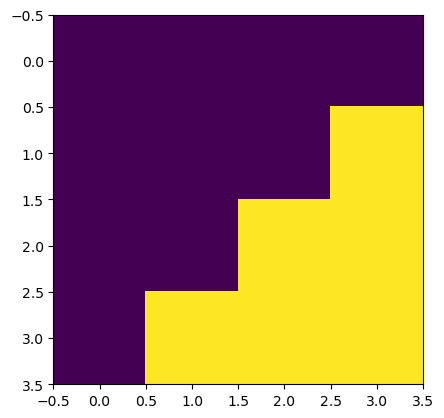

In [6]:
plt.imshow(construct_product_table(basic_table,1))

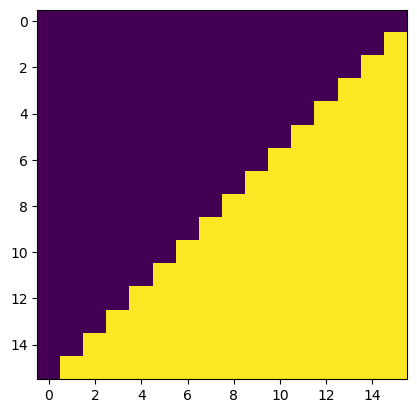

In [7]:
plt.imshow(construct_product_table(basic_table,2))

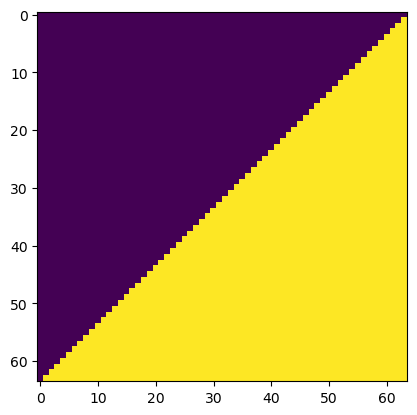

In [8]:
plt.imshow(construct_product_table(basic_table,3))

### Alternative Table, depth $\in [1:4]$

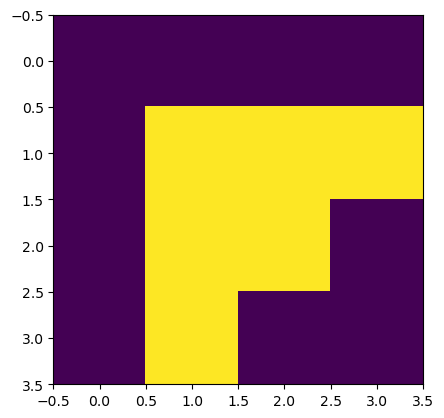

In [9]:
plt.imshow(construct_product_table(alt_table,1))

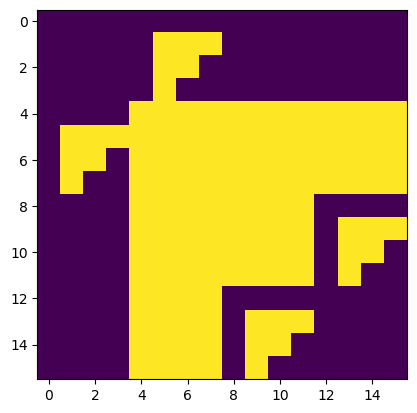

In [10]:
plt.imshow(construct_product_table(alt_table,2))

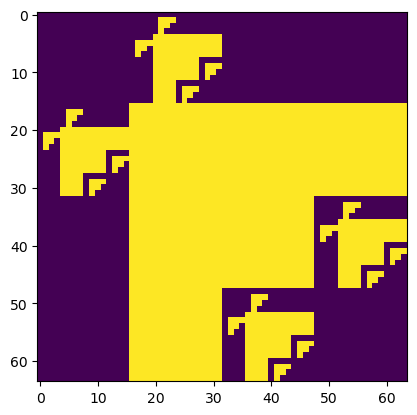

In [11]:
plt.imshow(construct_product_table(alt_table,3))

## Compare Carry Tables

### Find alternative cocycles

In [55]:
def assert_cocycle(table, depth=2, sample=False, n_samples=None):
    d=table.shape[0]
    tuples = list(product(*[range(d)]*depth))
    if sample:
        tuples = random.sample(tuples, n_samples)
    for v1 in tuples: #iterate over all tuples of given depth
        for v2 in tuples:
            for v3 in tuples:
                g1=RecursiveGrpElt(v1, table)
                g2=RecursiveGrpElt(v2, table)
                g3=RecursiveGrpElt(v3, table)

                s1=(g1+g2)+g3
                s2=g1+(g2+g3)
                is_assoc=s1.vals==s2.vals
                if not is_assoc:
                    return False
    return True

In [90]:
def assert_cocycle_worker(args):
    v1, v2, v3, table = args
    g1 = RecursiveGrpElt(v1, table)
    g2 = RecursiveGrpElt(v2, table)
    g3 = RecursiveGrpElt(v3, table)

    s1 = (g1 + g2) + g3
    s2 = g1 + (g2 + g3)
    is_assoc = np.array_equal(s1.vals, s2.vals)
    
    return is_assoc

def assert_cocycle(table, depth=2, num_processes=12, sample=False, n_samples=None):
    d = table.shape[0]
    tuples = list(product(*[range(d)] * depth))
    if sample:
        tuples = random.sample(tuples, n_samples)

    # Prepare arguments for the worker function
    worker_args = [(v1, v2, v3, table) for v1 in tuples for v2 in tuples for v3 in tuples]

    # Use multiprocessing.Pool to parallelize the workload
    with Pool(processes=num_processes) as pool:
        results = pool.map(assert_cocycle_worker, worker_args)

    # Check if any result is False, indicating a failure
    return all(results)

In [56]:
def construct_table(d, h):
    basic_table=1*(np.add.outer(np.arange(d),np.arange(d))>=d)
    table = np.zeros((d, d), dtype='int')
    for i in range(d):
        for j in range(d):
            table[i, j] = (basic_table[i, j] + h[(i+j)%d] - h[i] - h[j]) % d
    return table

In [62]:
def construct_tables(d, sample=False, n_samples=None):
    table_dict = {}
    for h in product(*[range(d)]*(d-1)):
        h = (0,) + h
        table = construct_table(d, h)
        if assert_cocycle(table, sample=sample, n_samples=n_samples):
            if not any([np.array_equal(table, o_table) for o_table in table_dict.values()]):
                table_dict[str(h)] = table
    return table_dict

In [91]:
tables3 = construct_tables(3)

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/cutterdawes/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/cutterdawes/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/cutterdawes/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/cutterdawes/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'assert_cocycle_worker' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/cutterdawes/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/cutterdawes/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/U

KeyboardInterrupt: 

In [83]:
tables4 = construct_tables(4)

In [85]:
tables5 = construct_tables(5)

In [88]:
tables6 = construct_tables(6, sample=True, n_samples=6^2 // 2)

### Plot their carry tables

In [18]:
def show_tables(table_dict, d):
    
    # create fig, axes
    n = len(table_dict)
    w = int(np.ceil(np.sqrt(n)))
    fig, axes = plt.subplots(n//w, w, figsize=(2*w, 2*n//w))
    axes = axes.flatten()
    
    # iterate through table_dict
    i = 0
    for h in table_dict.keys():
        ax = axes[i]
        h = list(table_dict.keys())[i]
        i += 1
        im = ax.imshow(table_dict[h], cmap='viridis', vmin=0, vmax=d-1)
        ax.set_title('h = ' + h)
        ax.axis('off')
        
    # add colorbar
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.94, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks(range(d))

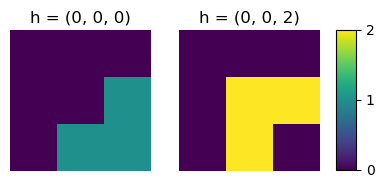

In [19]:
show_tables(tables3, 3)

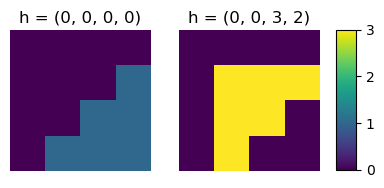

In [20]:
show_tables(tables4, 4)

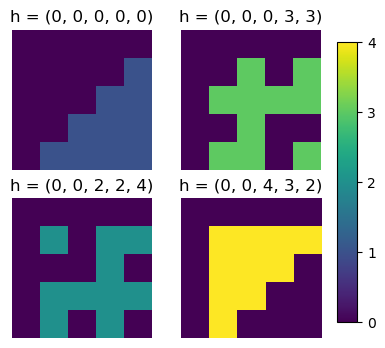

In [21]:
show_tables(tables5, 5)

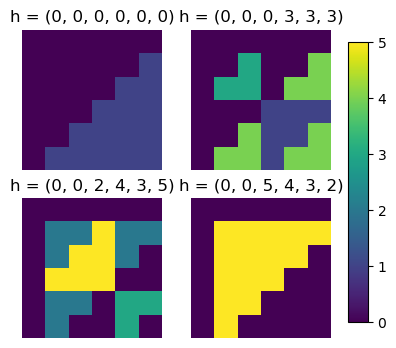

In [22]:
show_tables(tables6, 6)

In [ ]:
for h in tables6.keys():
    print(h, assert_cocycle(tables6[h], depth=3))

### Check how the recursive tables compare in terms of isomorphisms of groups

In [ ]:
h = '(0, 0, 0, 0, 0, 0)'
zero = RecursiveGrpElt((0, 0), tables6[h])
one = RecursiveGrpElt((0, 1), tables6[h])
cycle = [e.vals]
for t in range(g.d**len(g.vals) - 1):
    e += g
    cycle.append(e.vals)

### Count number of zeros in each table

In [26]:
for h in tables4.keys():
    table = tables4[h]
    print(h, table.size - np.count_nonzero(table))

(0, 0, 0, 0) 10
(0, 0, 3, 2) 10
